In [1]:
import pandas as pd, numpy as np
import random 
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.image import imread

### Recordar: en PCA, queremos combinaciones lineales con Varianza Máxima:

$ X = (x_1, x_2, \ldots, x_p)^T $   i.e.: tenemos $p$ variables

1. Encontrar c.lineal $\mathbf{w_1}^TX$ con **varianza máxima**
2. Encontrar otra c.lineal $\mathbf{w_2}^TX$ **no correlacionada** con c.lineal $\mathbf{w_1}^TX$ y con máxima varianza.
3. Iterar.

##### Clase pasada:
Al plantear PCA como problema de optimización obtenemos que la solución al problema son los eigenvectores de $\Sigma$, la matriz de varianzas y covarianzas de $X$:

Es decir:
* 1. Los **pesos** del primer componente principal satisfacen:

$$ \Sigma \mathbf{w_1} = \lambda_1 \mathbf{w_1} $$

* 2. Los **pesos** del componente principal $i$ satisfacen:

$$ \Sigma \mathbf{w_i} = \lambda_i \mathbf{w_i} ,$$ 

con $\lambda_i$ el eigenvalor $i$ de $\Sigma$

* 3. El primer componente principal se obtiene multiplicando $\mathbf{w_1}$ por nuestras variables originales $X$. En la práctica, si nuestras variables están en una tabla $\mathbf{X}$: 

$$
 PC_i = \mathbf{X}\mathbf{w_i}
$$

* 4. Como $\Sigma$ en la práctica es (casi siempre) desconocida, utilizamos $\mathbf{X}^{T}\mathbf{X}$ para estimarla y encontramos los eigenvalores y eigenvectores de esta matriz.

* 5. El porcentaje de variabilidad capturada por los primeros $q$ componentes ppales es:

$$
\frac{\sum_{i=1}^{q}\lambda_i}{\sum_{i=1}^{p}\lambda_i} \times 100
$$

In [3]:
from pca import pca

In [4]:
df=pd.read_csv("municipios_vcz.csv",encoding='latin-1')
df.set_index('Clave_mun',inplace=True)
df.head()

,longitud,latitud,altitud,totreg,ingtoper,Censo_y_edu,Censo_y_salud,Censo_y_ss,Censo_y_cv,Censo_y_sbv,...,Enigh_y_edu,Enigh_y_salud,Enigh_y_ss,Enigh_y_cv,Enigh_y_sbv,Enigh_y_ali2,Enigh_y_ing,Nb_mun,Population,Gini_coef
Clave_mun,,,,,,,,,,,,,,,,,,,,,
1,970033,193513,2020,7503,2550526,0.3675,0.9230,0.9152,0.6040,0.7520,...,0.342191,0.550816,0.905494,0.288390,0.189470,0.220319,1.11925,Acajete,7117,0.438707
2,965031,194150,1740,2558,1532146,0.3753,0.9629,0.9582,0.1443,0.0696,...,0.306714,0.480169,0.959326,0.089450,0.126147,0.305756,1.50103,Acatlán,2983,0.370577
3,945448,175654,100,77737,55300000,0.2782,0.7804,0.7487,0.4183,0.5256,...,0.274846,0.261125,0.744406,0.292389,0.561117,0.229383,1.62541,Acayucan,91089,0.430602
4,963709,193013,260,39308,26100000,0.4237,0.6479,0.6382,0.3576,0.3437,...,0.327091,0.489681,0.725265,0.087810,0.117200,0.217913,1.67230,Actopan,44150,0.394426
5,954624,183022,10,5017,5645295,0.3889,0.6303,0.6418,0.3117,0.8597,...,0.314982,0.074335,0.769867,0.142259,0.542609,0.297072,1.57418,Acula,4630,0.396407


In [6]:
X=df.iloc[:,5:13]
X.head()

,Censo_y_edu,Censo_y_salud,Censo_y_ss,Censo_y_cv,Censo_y_sbv,Censo_y_ali,Censo_y_ing,Censo_y_esco
Clave_mun,,,,,,,,
1,0.3675,0.9230,0.9152,0.6040,0.7520,0.1801,0.3399,3.3900
2,0.3753,0.9629,0.9582,0.1443,0.0696,0.0797,0.5990,3.5813
3,0.2782,0.7804,0.7487,0.4183,0.5256,0.2064,0.7114,4.7598
4,0.4237,0.6479,0.6382,0.3576,0.3437,0.0509,0.6640,3.9212
5,0.3889,0.6303,0.6418,0.3117,0.8597,0.1023,1.1252,3.8657


#### Significado variables

1. **Censo_y_edu**:  rezago educativo
2. **Censo_y_salud**: carencia en servicios de salud
3. **Censo_y_ss**:   acceso a seg social (carencia)
4. **Censo_y_cv**:   calidad de la vivienda (carencia)
5. **Censo_y_sbv**:  servicios básicos de la vivienda (carencia)
6. **Censo_y_ali**:  alimentación (carencia)
7. **Censo_y_ing**:   ingreso en pesos mexicanos
8. **Censo_y_esco**:   años de escolaridad

In [7]:
from sklearn.preprocessing import StandardScaler

#Lo siguiente lo hacemos para estandarizar variables y que las unidades de medición no sean un factor que afecta la solución. 

scaler=StandardScaler().fit(X) #Calculamos los datos de la media y varianza de c/variable. 
X_norm=scaler.transform(X) #Aplicamos estandarización


Para cada variable $X_i$, `StandardScaler()` aplica la estandarización:

$$
\frac{X_i - \mu_i}{\sigma_i}
$$

$$
\frac{(X_i - \mu_i)(X_i - \mu_i)}{\sigma_i^{2}}
$$

In [9]:
X_norm=pd.DataFrame(X_norm, index=range(1,211))
X_norm.columns=X.columns
X_norm.head()

,Censo_y_edu,Censo_y_salud,Censo_y_ss,Censo_y_cv,Censo_y_sbv,Censo_y_ali,Censo_y_ing,Censo_y_esco
1,0.466518,0.771293,0.738552,0.273132,0.458197,-0.314346,-0.637023,-0.397685
2,0.571370,0.998286,0.978340,-1.782627,-2.350908,-0.870779,0.135251,-0.230888
3,-0.733896,-0.039964,-0.189929,-0.557310,-0.473781,-0.168587,0.470271,0.796663
4,1.221987,-0.793762,-0.806128,-0.828758,-1.222573,-1.030393,0.328990,0.065476
5,0.754188,-0.893889,-0.786053,-1.034021,0.901544,-0.745526,1.703644,0.017085


In [10]:
#Aquí inicializamos el modelo, especificando que queremos reducir nuestro dataset a 4 PCs. 
#aquellosque capturan la mayor variabilidad de los datos
pca_model=pca(n_components=4)

In [11]:
res=pca_model.fit_transform(X_norm)
#pca_model.fit_transform(): aplica el modelo pca al dataset normalizado 'X_norm'. 
#y nos transforma los datos segun el modelo especificado. 
#El resultado (res) es nuestro dataset transforma representado en términos de los componentes principales

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 4 Principal Components explain [94.37%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

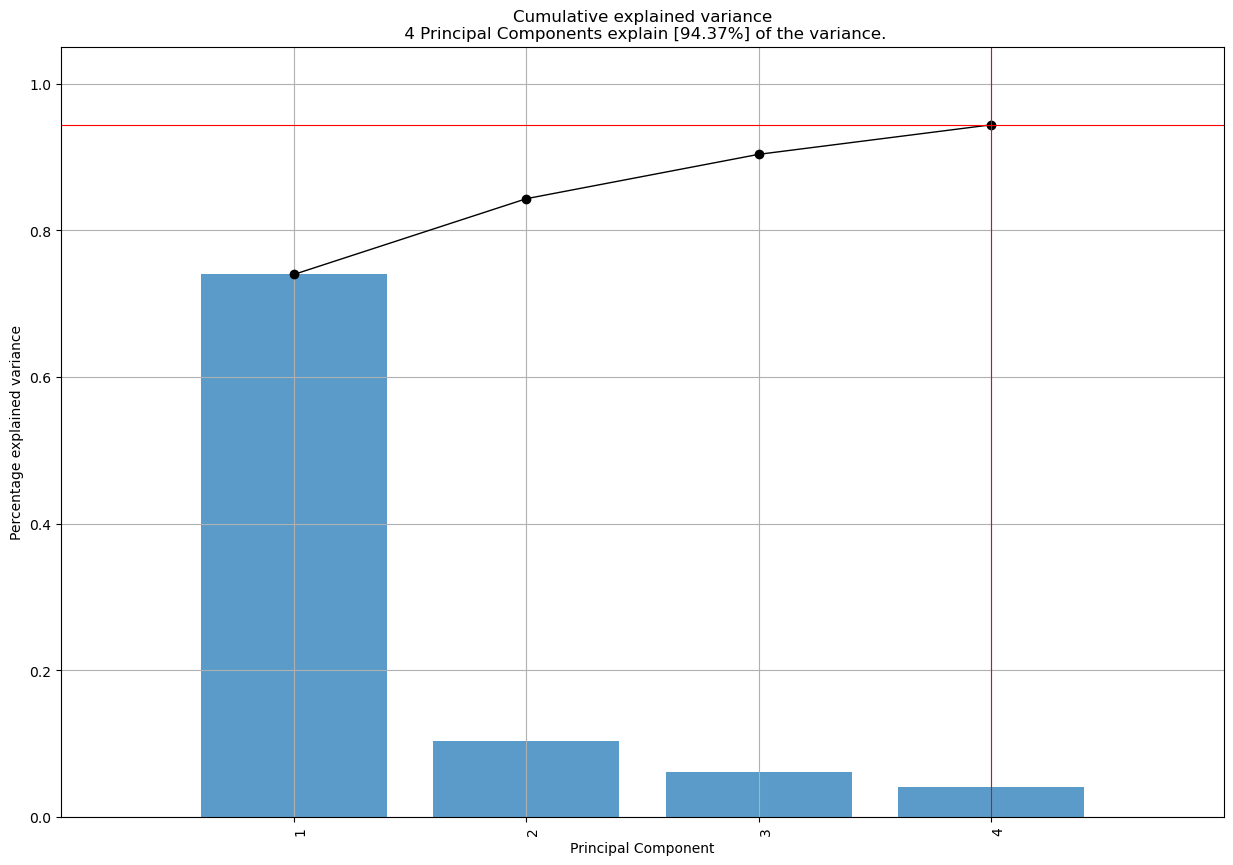

In [12]:
pca_model.plot()
#Esta gráfica a el porcentaje de varianza acumulado y explicada por nuestrso PCs. Nos ayuda a entenerder 
#la 'calidad' de la reducciónd e información. 

[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '4 Principal Components explain [94.37%] of the variance'}, xlabel='PC1 (73.9% expl.var)', ylabel='PC2 (10.3% expl.var)'>)

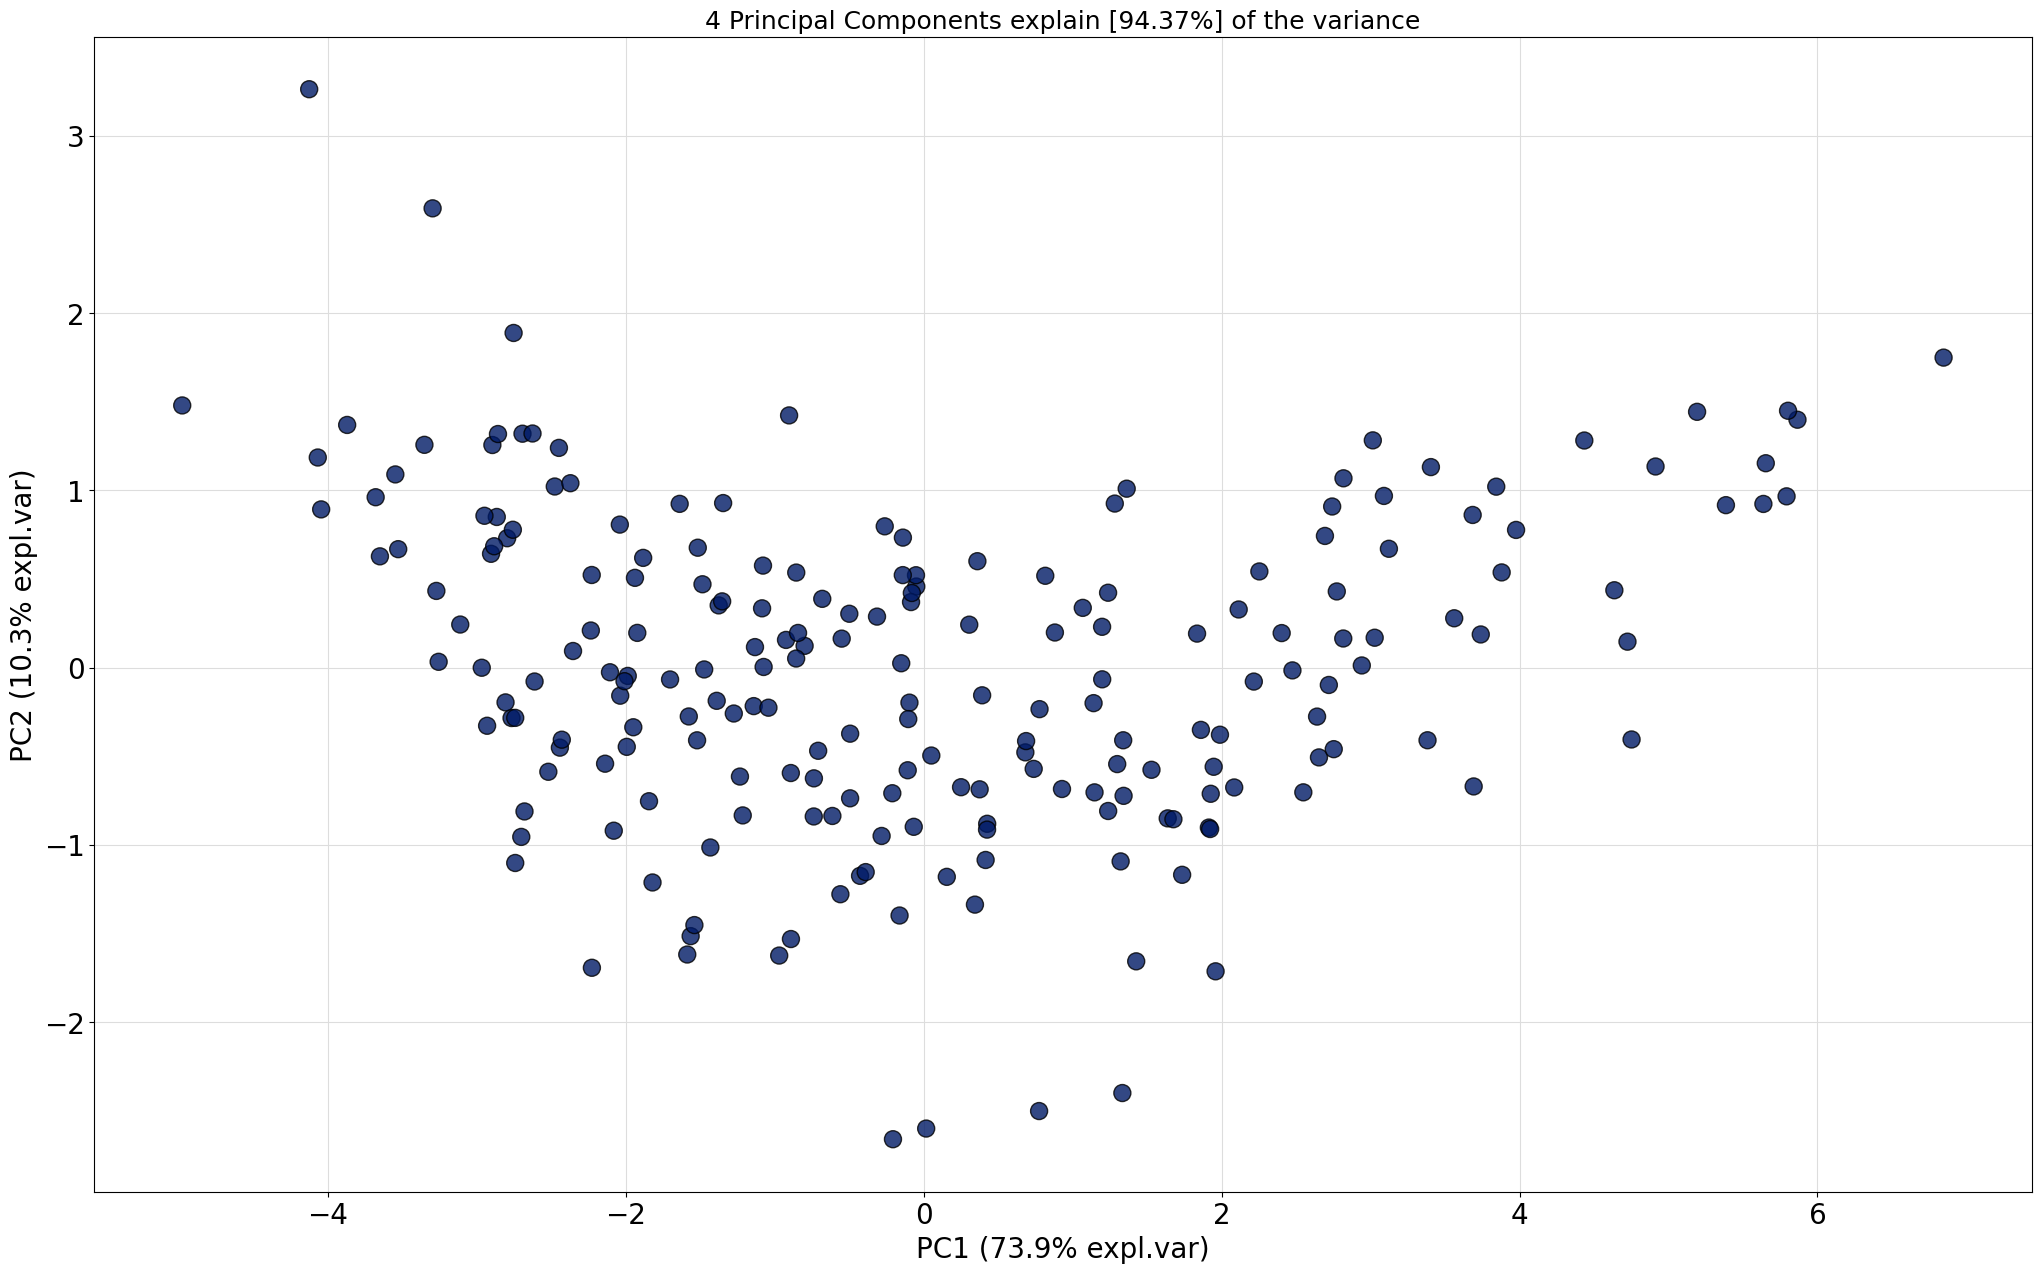

In [13]:
pca_model.scatter()


[scatterd] >INFO> Create scatterplot


[pca]> [WARNING]: De parameter <label> is deprecated and will not be supported in future version.
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '4 Principal Components explain [94.37%] of the variance'}, xlabel='PC1 (73.9% expl.var)', ylabel='PC2 (10.3% expl.var)'>)

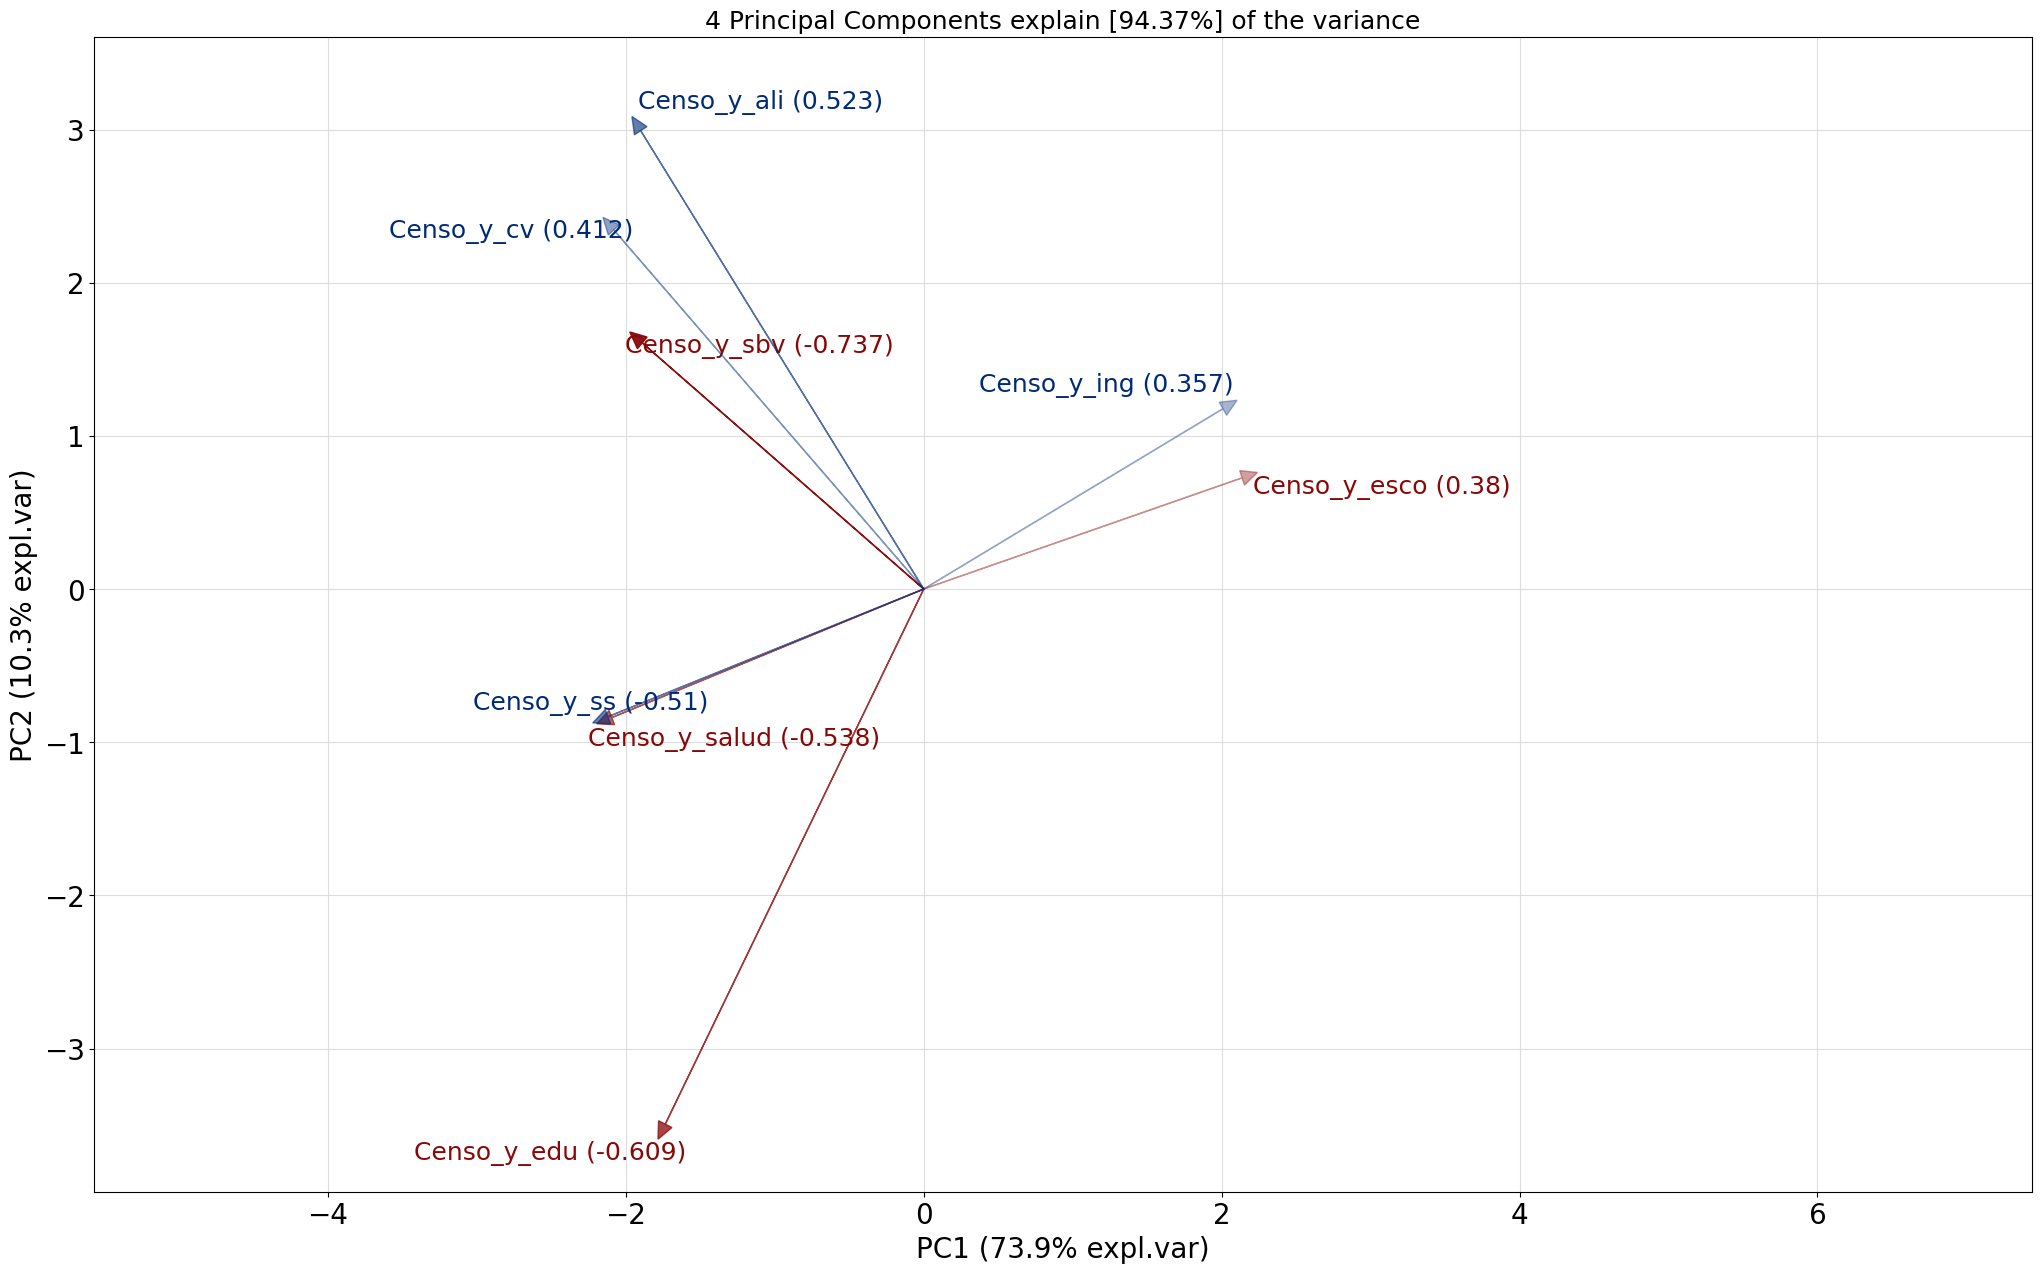

In [14]:
pca_model.biplot(n_feat=8,legend=False, label=False,cmap=None)

#Proyección de las variables en los 2 primeros componentes principales. 
#n_feat=8 especifica que las top 8 variables se mostraran en el gra´fico. 
#cmap=none signifca que no se usará plate de colores --> no muestras las observacioens (muni

#Este gráfico puede ayudarnos a ver si hay dimensiones 'latentes' en lso datos. 

#Una dimension latente es una variable no observada directamente que puede ser inferida a partir de otras variables observadas en un conjunto 
#de datos,. En el contexto de PCA, las dimensiones latentes son los componentes, que son combinanciones lineas de las varaibles orignales. 
#estos componentes capturan la mayor parte de variabilidad presente en los datos. 

#Usando Biplot para explicar dimensiones latetnes. Un biplot es una visualiación que muestra tnato las observaciones en un espacio reducido
#como las direcciones de las varaibles origianles, permitiendo un interpretación conjunta de la estructura de datos y de la contibución de cada 
#varible. 

[scatterd] >INFO> Create scatterplot


[pca]> [WARNING]: De parameter <label> is deprecated and will not be supported in future version.
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '4 Principal Components explain [94.37%] of the variance'}, xlabel='PC1 (73.9% expl.var)', ylabel='PC2 (10.3% expl.var)'>)

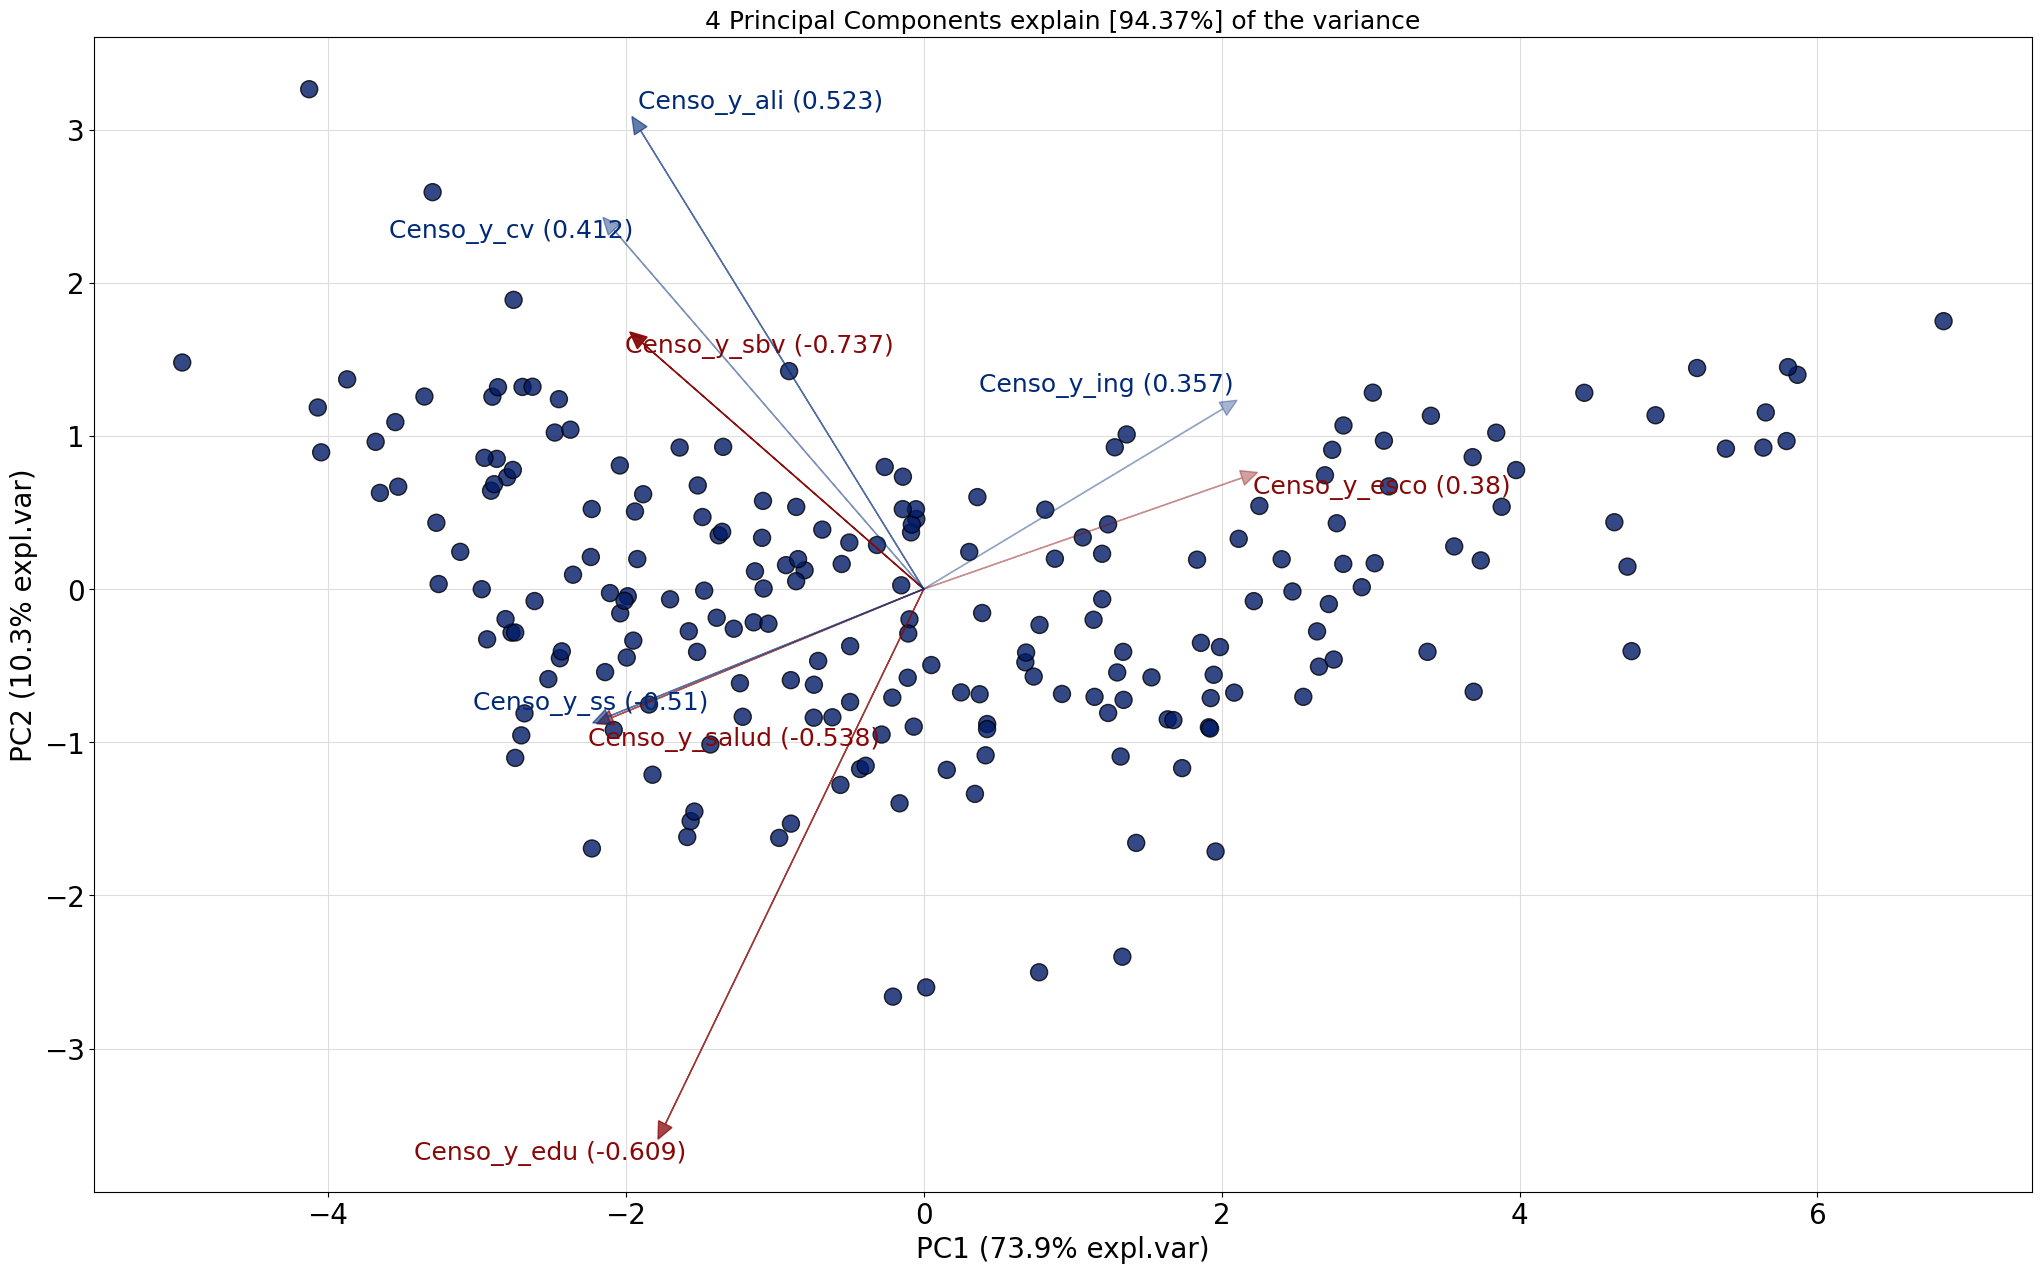

In [15]:
pca_model.biplot(n_feat=8,legend=False, label=False)


[scatterd] >INFO> Create scatterplot


[pca]> [WARNING]: De parameter <label> is deprecated and will not be supported in future version.
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '4 Principal Components explain [94.37%] of the variance'}, xlabel='PC1 (73.9% expl.var)', ylabel='PC2 (10.3% expl.var)'>)

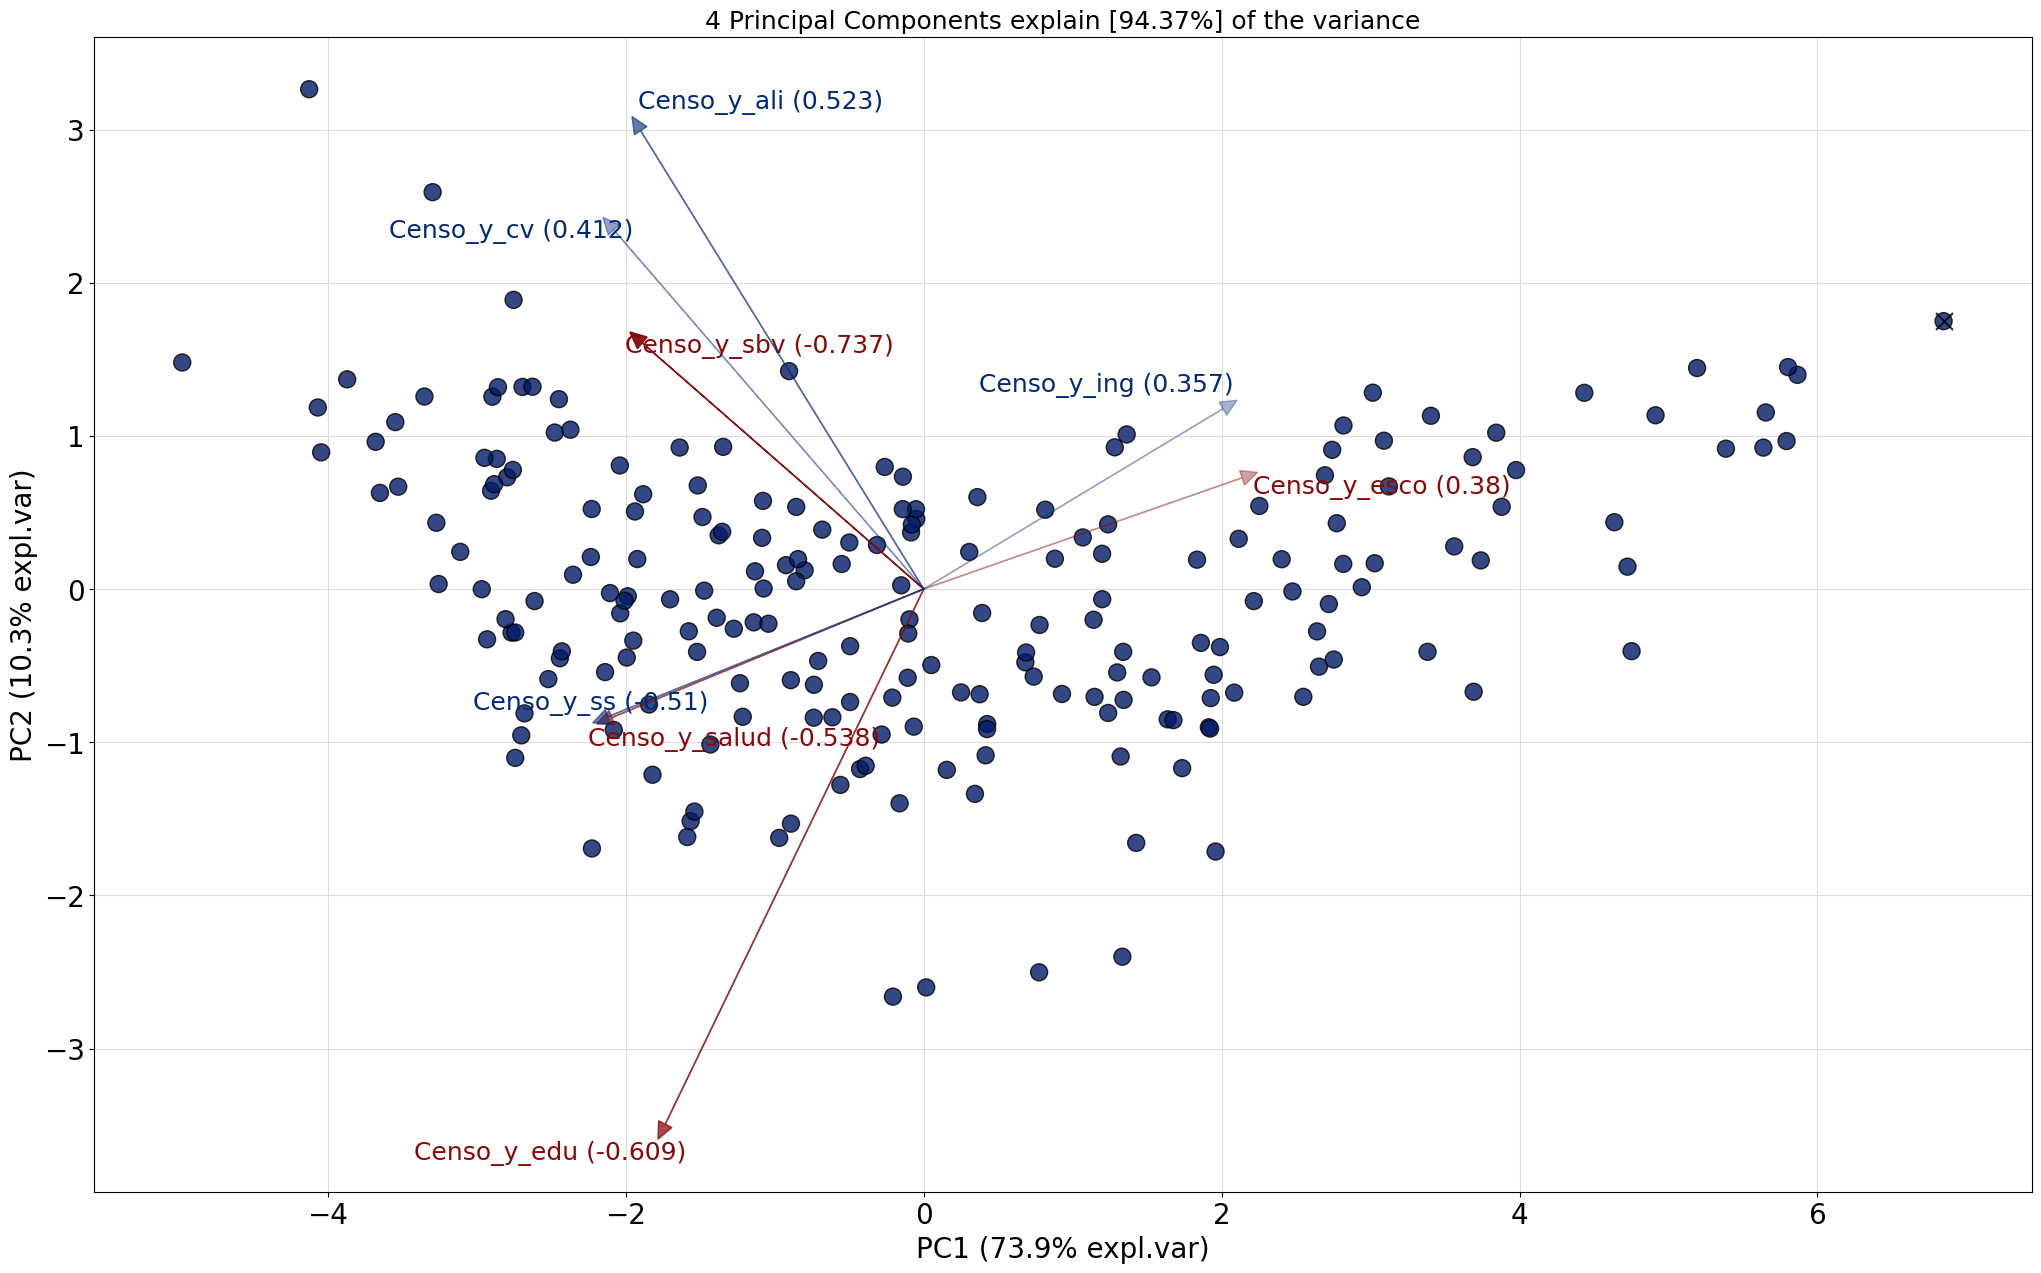

In [22]:
pca_model.biplot(n_feat=8,legend=False, label=True,HT2=True)
#se los reviso hotellingt2
#muestra valores típicos segun la distribución t2 DE H. Hotelling. 

[Sobre la distribución T^2 de Hotelling](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_T%C2%B2_de_Hotelling)


In [23]:
res

{'loadings':      Censo_y_edu  Censo_y_salud  Censo_y_ss  Censo_y_cv  Censo_y_sbv  \
 PC1    -0.302599      -0.372446   -0.376968   -0.365286    -0.334720   
 PC2    -0.609247      -0.149310   -0.148237    0.411579     0.284654   
 PC3     0.458557      -0.538107   -0.509935   -0.039857     0.419809   
 PC4     0.028932      -0.171576   -0.133532   -0.017973    -0.737238   
 
      Censo_y_ali  Censo_y_ing  Censo_y_esco  
 PC1    -0.332284     0.356726      0.380099  
 PC2     0.523227     0.209024      0.129102  
 PC3     0.103242    -0.021370     -0.226250  
 PC4     0.511271    -0.157864     -0.348901  ,
 'PC':           PC1       PC2       PC3       PC4
 1   -1.233932 -0.614993 -0.325122 -0.481567
 2    0.774391 -2.502225 -1.730503  1.093830
 3    1.197307  0.229944 -0.602562 -0.068098
 4    1.426329 -1.657497  0.790113  0.593822
 5    1.338928 -0.410223  1.530129 -1.021986
 ..        ...       ...       ...       ...
 206  5.802533  1.448864  0.550378  0.258635
 207  2.719598 -0.0

In [24]:
res.get('loadings')
#loadings son los coeficientes de la combinación lineal de (w_i). Es decir, los pesos por los que 
#cada variable es multiplicada para formar un componente princiapl 

,Censo_y_edu,Censo_y_salud,Censo_y_ss,Censo_y_cv,Censo_y_sbv,Censo_y_ali,Censo_y_ing,Censo_y_esco
PC1,-0.302599,-0.372446,-0.376968,-0.365286,-0.334720,-0.332284,0.356726,0.380099
PC2,-0.609247,-0.149310,-0.148237,0.411579,0.284654,0.523227,0.209024,0.129102
PC3,0.458557,-0.538107,-0.509935,-0.039857,0.419809,0.103242,-0.021370,-0.226250
PC4,0.028932,-0.171576,-0.133532,-0.017973,-0.737238,0.511271,-0.157864,-0.348901


In [31]:
w=res.get('loadings')


$PC1 =  -0.302 x Censo_y_edu -0.372 x Censo_y_salud+...+0.356 x Censo_y_ing + 0.38 x Censo_y_esco$

In [26]:
X_norm.head()

,Censo_y_edu,Censo_y_salud,Censo_y_ss,Censo_y_cv,Censo_y_sbv,Censo_y_ali,Censo_y_ing,Censo_y_esco
1,0.466518,0.771293,0.738552,0.273132,0.458197,-0.314346,-0.637023,-0.397685
2,0.571370,0.998286,0.978340,-1.782627,-2.350908,-0.870779,0.135251,-0.230888
3,-0.733896,-0.039964,-0.189929,-0.557310,-0.473781,-0.168587,0.470271,0.796663
4,1.221987,-0.793762,-0.806128,-0.828758,-1.222573,-1.030393,0.328990,0.065476
5,0.754188,-0.893889,-0.786053,-1.034021,0.901544,-0.745526,1.703644,0.017085


In [29]:
X_norm.shape

(210, 8)

In [28]:
X_norm.iloc[0,:]

Censo_y_edu      0.466518
Censo_y_salud    0.771293
Censo_y_ss       0.738552
Censo_y_cv       0.273132
Censo_y_sbv      0.458197
Censo_y_ali     -0.314346
Censo_y_ing     -0.637023
Censo_y_esco    -0.397685
Name: 1, dtype: float64

In [32]:
w.iloc[0,:]

Censo_y_edu     -0.302599
Censo_y_salud   -0.372446
Censo_y_ss      -0.376968
Censo_y_cv      -0.365286
Censo_y_sbv     -0.334720
Censo_y_ali     -0.332284
Censo_y_ing      0.356726
Censo_y_esco     0.380099
Name: PC1, dtype: float64

In [34]:
sum(X_norm.iloc[0,:]*w.iloc[0,:])

-1.2339324238270402

In [35]:
sum(X_norm.iloc[1,:]*w.iloc[0,:])

0.7743914169642396

In [36]:
sum(X_norm.iloc[2,:]*w.iloc[0,:])

1.1973069726604821

In [38]:
X_norm@w.T

,PC1,PC2,PC3,PC4
1,-1.233932,-0.614993,-0.325122,-0.481567
2,0.774391,-2.502225,-1.730503,1.093830
3,1.197307,0.229944,-0.602562,-0.068098
4,1.426329,-1.657497,0.790113,0.593822
5,1.338928,-0.410223,1.530129,-1.021986
...,...,...,...,...
206,5.802533,1.448864,0.550378,0.258635
207,2.719598,-0.098176,1.208257,0.013406
208,3.691907,-0.670700,1.662859,0.805206
209,-2.883924,0.684456,-0.109996,0.219746


In [ ]:
#PCA(210x8)
#X_norm(210x8)
#PCA(210x8)= X_norm(210x8) W(8x8)

In [27]:
res.get('PC')
#aquí obtenemos ya los componentes principales, Xw_1, Xw_2,Xw_3,Xw_4

,PC1,PC2,PC3,PC4
1,-1.233932,-0.614993,-0.325122,-0.481567
2,0.774391,-2.502225,-1.730503,1.093830
3,1.197307,0.229944,-0.602562,-0.068098
4,1.426329,-1.657497,0.790113,0.593822
5,1.338928,-0.410223,1.530129,-1.021986
...,...,...,...,...
206,5.802533,1.448864,0.550378,0.258635
207,2.719598,-0.098176,1.208257,0.013406
208,3.691907,-0.670700,1.662859,0.805206
209,-2.883924,0.684456,-0.109996,0.219746


In [39]:
res.get('topfeat')
#Significa 'top features': representa las variables originales más importantes de cada componente principal

#entender cuáles variables tienen el mayor impacto en cada componente. Aquí nos dan las variables que más contribuyen en cada componente. 
#Esto es importante para interpretar los resultados de los PCA, ya que resalta qué variables están llevando los patrones capturadaos por 
#cada componente. 

,PC,feature,loading,type
0,PC1,Censo_y_esco,0.380099,best
1,PC2,Censo_y_edu,-0.609247,best
2,PC3,Censo_y_salud,-0.538107,best
3,PC4,Censo_y_sbv,-0.737238,best
4,PC3,Censo_y_ss,-0.509935,weak
5,PC2,Censo_y_cv,0.411579,weak
6,PC2,Censo_y_ali,0.523227,weak
7,PC1,Censo_y_ing,0.356726,weak


In [40]:
res.get('pcp')
#nos da la varianza capturada por los PCs, en nuestro caso por los 4 primeros. 

0.9437076389426842

In [41]:
outl=res.get('outliers')
outl #son observaciones que han sido identificados como anormales o atípicos. Los outliers pueden influir en los componentes principales. 
#se puede explorar quitarlos y estudiar si realmante reflejan el comportamiento de la base original. 

,y_proba,p_raw,y_score,y_bool,y_bool_spe,y_score_spe
1,0.997717,0.866361,3.896249,False,False,1.378697
2,0.997717,0.184041,11.323367,False,False,2.619315
3,0.997717,0.927198,3.111032,False,False,1.219187
4,0.997717,0.501604,7.328846,False,False,2.186713
5,0.997717,0.539497,6.973477,False,False,1.400361
...,...,...,...,...,...,...
206,0.093990,0.001677,24.805495,False,False,5.980685
207,0.997717,0.418371,8.156113,False,False,2.721369
208,0.702397,0.060205,14.945925,False,False,3.752335
209,0.997717,0.431059,8.024719,False,False,2.964034


In [44]:
is_outl=outl['y_bool']
is_outl

1      False
2      False
3      False
4      False
5      False
       ...  
206    False
207    False
208    False
209    False
210    False
Name: y_bool, Length: 210, dtype: bool

In [46]:
is_outl[28]

True

In [45]:
indices_outliers=[i for i in is_outl.index if is_outl[i]]
indices_outliers

[28]

### Proposición: Diagonalización de Matrices Simétricas

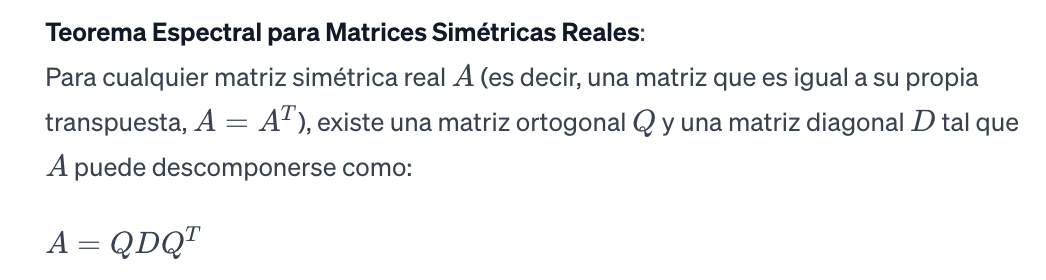



$$Q=E$$

entonces

$$A = E\Lambda E^{T}$$

##### Implicaciones

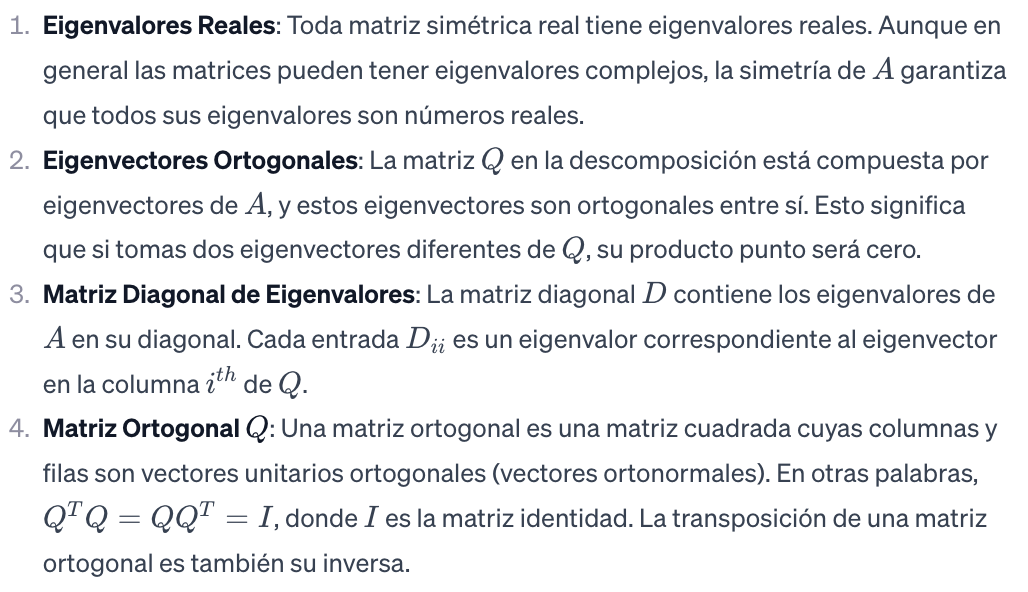

Apliquemos este resultado al ejemplo anterior. Basta sacar los eigenvectores y eigenvalores de $X^{T}X$ (versión estandarizada), ya que $X^{T}X$ es una matriz simétrica

In [47]:
l, e= la.eig(X_norm.T@X_norm)
print(l, "\n"*3, e)

[1.24260282e+03 1.73569045e+02 1.01652265e+02 1.18627624e+00
 1.64110236e+01 2.36005458e+01 5.33733209e+01 6.76047061e+01] 


 [[-0.30259903  0.60924704 -0.45855701 -0.01769078 -0.23971704 -0.40586657
   0.32192446 -0.02893248]
 [-0.37244577  0.14930995  0.53810739  0.68963696 -0.11773051  0.05312717
   0.16646575  0.17157554]
 [-0.37696794  0.14823653  0.50993468 -0.72203873 -0.08588958  0.10651697
   0.13414257  0.13353158]
 [-0.3652855  -0.41157914  0.0398566  -0.01425681  0.50367641 -0.6636012
   0.03158793  0.017973  ]
 [-0.33472018 -0.28465394 -0.41980863 -0.00139338 -0.11359763  0.26669083
  -0.05607693  0.73723827]
 [-0.33228445 -0.52322747 -0.10324184  0.00370658 -0.56219111  0.06782532
   0.15195503 -0.51127096]
 [ 0.35672608 -0.20902388  0.02137035 -0.02254442  0.08230301  0.04421678
   0.891314    0.15786398]
 [ 0.38009945 -0.12910189  0.22625013 -0.04495316 -0.5760827  -0.55050706
  -0.17025327  0.34890075]]


In [49]:
E=pd.DataFrame(e)
E #aquí tenemos la mtriz cuyas columnas son los eigenvectores de (X_norm_t X_norm)

,0,1,2,3,4,5,6,7
0,-0.302599,0.609247,-0.458557,-0.017691,-0.239717,-0.405867,0.321924,-0.028932
1,-0.372446,0.149310,0.538107,0.689637,-0.117731,0.053127,0.166466,0.171576
2,-0.376968,0.148237,0.509935,-0.722039,-0.085890,0.106517,0.134143,0.133532
3,-0.365286,-0.411579,0.039857,-0.014257,0.503676,-0.663601,0.031588,0.017973
4,-0.334720,-0.284654,-0.419809,-0.001393,-0.113598,0.266691,-0.056077,0.737238
5,-0.332284,-0.523227,-0.103242,0.003707,-0.562191,0.067825,0.151955,-0.511271
6,0.356726,-0.209024,0.021370,-0.022544,0.082303,0.044217,0.891314,0.157864
7,0.380099,-0.129102,0.226250,-0.044953,-0.576083,-0.550507,-0.170253,0.348901


In [50]:
D=np.diag(l)
D

array([[1.24260282e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.73569045e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.01652265e+02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.18627624e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.64110236e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.36005458e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.33733209e+01, 0.

In [51]:
E@D@E.T 

,0,1,2,3,4,5,6,7
0,210.000000,133.213926,135.026014,96.853124,110.812663,79.598282,-142.973296,-163.187072
1,133.213926,210.000000,208.646070,159.241036,133.174739,131.168880,-159.713356,-163.960400
2,135.026014,208.646070,210.000000,160.606401,134.790526,134.267521,-163.547384,-168.243201
3,96.853124,159.241036,160.606401,210.000000,166.250722,181.710909,-145.218253,-158.392073
4,110.812663,133.174739,134.790526,166.250722,210.000000,144.000122,-133.630471,-145.860961
5,79.598282,131.168880,134.267521,181.710909,144.000122,210.000000,-127.449142,-156.598781
6,-142.973296,-159.713356,-163.547384,-145.218253,-133.630471,-127.449142,210.000000,167.934417
7,-163.187072,-163.960400,-168.243201,-158.392073,-145.860961,-156.598781,167.934417,210.000000


In [52]:
X_norm.T@X_norm #verifica el teorme de Diagonilización (T. Espectral)

,Censo_y_edu,Censo_y_salud,Censo_y_ss,Censo_y_cv,Censo_y_sbv,Censo_y_ali,Censo_y_ing,Censo_y_esco
Censo_y_edu,210.000000,133.213926,135.026014,96.853124,110.812663,79.598282,-142.973296,-163.187072
Censo_y_salud,133.213926,210.000000,208.646070,159.241036,133.174739,131.168880,-159.713356,-163.960400
Censo_y_ss,135.026014,208.646070,210.000000,160.606401,134.790526,134.267521,-163.547384,-168.243201
Censo_y_cv,96.853124,159.241036,160.606401,210.000000,166.250722,181.710909,-145.218253,-158.392073
Censo_y_sbv,110.812663,133.174739,134.790526,166.250722,210.000000,144.000122,-133.630471,-145.860961
Censo_y_ali,79.598282,131.168880,134.267521,181.710909,144.000122,210.000000,-127.449142,-156.598781
Censo_y_ing,-142.973296,-159.713356,-163.547384,-145.218253,-133.630471,-127.449142,210.000000,167.934417
Censo_y_esco,-163.187072,-163.960400,-168.243201,-158.392073,-145.860961,-156.598781,167.934417,210.000000


In [53]:
round(E.T@E,0)

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
1,0.0,1.0,0.0,-0.0,0.0,0.0,-0.0,0.0
2,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0
3,0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0
4,-0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0
5,0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0
6,-0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,0.0
7,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0


In [54]:
round(E@E.T,0)

,0,1,2,3,4,5,6,7
0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0
1,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
2,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0
3,0.0,-0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0
4,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0
5,-0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0,-0.0
6,0.0,0.0,0.0,0.0,0.0,-0.0,1.0,0.0
7,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,1.0


In [55]:
res['loadings'] #los coefs para calcular los PCs

,Censo_y_edu,Censo_y_salud,Censo_y_ss,Censo_y_cv,Censo_y_sbv,Censo_y_ali,Censo_y_ing,Censo_y_esco
PC1,-0.302599,-0.372446,-0.376968,-0.365286,-0.334720,-0.332284,0.356726,0.380099
PC2,-0.609247,-0.149310,-0.148237,0.411579,0.284654,0.523227,0.209024,0.129102
PC3,0.458557,-0.538107,-0.509935,-0.039857,0.419809,0.103242,-0.021370,-0.226250
PC4,0.028932,-0.171576,-0.133532,-0.017973,-0.737238,0.511271,-0.157864,-0.348901


In [57]:
res['loadings'].T

,PC1,PC2,PC3,PC4
Censo_y_edu,-0.302599,-0.609247,0.458557,0.028932
Censo_y_salud,-0.372446,-0.149310,-0.538107,-0.171576
Censo_y_ss,-0.376968,-0.148237,-0.509935,-0.133532
Censo_y_cv,-0.365286,0.411579,-0.039857,-0.017973
Censo_y_sbv,-0.334720,0.284654,0.419809,-0.737238
Censo_y_ali,-0.332284,0.523227,0.103242,0.511271
Censo_y_ing,0.356726,0.209024,-0.021370,-0.157864
Censo_y_esco,0.380099,0.129102,-0.226250,-0.348901


In [56]:
E

,0,1,2,3,4,5,6,7
0,-0.302599,0.609247,-0.458557,-0.017691,-0.239717,-0.405867,0.321924,-0.028932
1,-0.372446,0.149310,0.538107,0.689637,-0.117731,0.053127,0.166466,0.171576
2,-0.376968,0.148237,0.509935,-0.722039,-0.085890,0.106517,0.134143,0.133532
3,-0.365286,-0.411579,0.039857,-0.014257,0.503676,-0.663601,0.031588,0.017973
4,-0.334720,-0.284654,-0.419809,-0.001393,-0.113598,0.266691,-0.056077,0.737238
5,-0.332284,-0.523227,-0.103242,0.003707,-0.562191,0.067825,0.151955,-0.511271
6,0.356726,-0.209024,0.021370,-0.022544,0.082303,0.044217,0.891314,0.157864
7,0.380099,-0.129102,0.226250,-0.044953,-0.576083,-0.550507,-0.170253,0.348901


* Una matriz ortogonal es una matriz de rotación
* Una matriz diagonal es una matriz que escala los vectores.
* La descomposición espectral de las matrices simétricas es como entender la acción de una matriz en 3 pasos: a) rotación, b) escalamiento  c) rotación.


In [58]:
M=np.array([
    [1,2],
    [2,3]
])
M

array([[1, 2],
       [2, 3]])

In [60]:
l,e=la.eig(M) #tupla
print('Eigenvalores:')
print(l)

print('\nEigenvectores:')
print(e)

Eigenvalores:
[-0.23606798  4.23606798]

Eigenvectores:
[[-0.85065081 -0.52573111]
 [ 0.52573111 -0.85065081]]


In [62]:
la.eig(M)#tupla

(array([-0.23606798,  4.23606798]),
 array([[-0.85065081, -0.52573111],
        [ 0.52573111, -0.85065081]]))

In [65]:
ejemplo1=(1,2)

In [67]:
ejemplo1[1]=3 #las tuplas son inmutables, es decir, no puedo cambiarlas directamente. Esto las hace más rápidas
#a diferencia de las litas y otros objetos mutables. 

TypeError: 'tuple' object does not support item assignment

In [61]:
D=np.diag(l)
D

array([[-0.23606798,  0.        ],
       [ 0.        ,  4.23606798]])

In [64]:
e@D@e.T

array([[1., 2.],
       [2., 3.]])